In [1]:
import sys
print(sys.executable)
#/Users/ibhallaladd/Desktop/venv/bin/python
sys.path



/Users/ibhallaladd/Desktop/venv/bin/python


['/Users/ibhallaladd/Desktop',
 '/Users/ibhallaladd/Desktop/build/lib',
 '/Users/ibhallaladd/.pyenv/versions/3.7.3/lib/python37.zip',
 '/Users/ibhallaladd/.pyenv/versions/3.7.3/lib/python3.7',
 '/Users/ibhallaladd/.pyenv/versions/3.7.3/lib/python3.7/lib-dynload',
 '',
 '/Users/ibhallaladd/Desktop/venv/lib/python3.7/site-packages',
 '/Users/ibhallaladd/Desktop/venv/lib/python3.7/site-packages/IPython/extensions',
 '/Users/ibhallaladd/.ipython']

In [2]:
from __future__ import division # Force python to turn integer division into a float result! Otherwise your fake rates will be all 0...
%load_ext autoreload
%autoreload 2
import os
import sys
import argparse
import glob
import numpy as np
import uproot
import pandas as pd
import pickle
import tables
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit 
from scipy import integrate


plt.rcParams['figure.figsize'] = (10, 7)
plt.rcParams['font.size'] = 14
pd.options.mode.chained_assignment = None  # default='warn'. This eliminates warnings when assigning new variables to dataframes during the cutflow.
#sys.path.append('/project/hep/demers/mnp3/ATLAS/vhtautau/python')
#from cutflow_functions import *
#from preselection_cutflows import *
#from signal_cutflows import *

In [3]:
#from ROOT import TFile, TTree
#from ROOT import gROOT, AddressOf
#from ROOT import GetQuantiles

In [4]:
# Grab a Ztautau sample with neutrino data saved
f = uproot.open("/Users/ibhallaladd/Desktop/hleptons_ztautau_lephad_mmc_test_file.root")
variables = [var.decode() for var in f["NOMINAL"].keys()] 
a = f["NOMINAL"].arrays(variables)

### New in Python3: decode bytestrings into actual strings, otherwise the strings won't be recognized below
def convert(data):
    if isinstance(data, bytes):  return data.decode()
    if isinstance(data, dict):   return dict(map(convert, data.items()))
    if isinstance(data, tuple):  return tuple(map(convert, data))
    if isinstance(data, list):   return list(map(convert, data))
    return data
a = convert(a)

df = pd.DataFrame.from_dict(a)

In [5]:
vars = df.keys()
[var for var in vars if "pt" in var]

['HTXS_Higgs_pt',
 'ditau_higgspt',
 'ditau_matched_scal_sum_pt',
 'ditau_matched_vis_scal_sum_pt',
 'ditau_matched_vis_vect_sum_pt',
 'ditau_mmc_maxw_pt',
 'ditau_scal_sum_pt',
 'lepton_eta_centrality',
 'met_hpto_p4',
 'n_truth_jets_pt20_eta45',
 'pt_total',
 'scalar_sum_pt',
 'tau_0_allTrk_pt',
 'tau_0_leadTrk_pt',
 'tau_1_cluster_pt',
 'tau_1_matched_leptonic_tau',
 'tau_1_matched_leptonic_tau_classifierParticleOrigin',
 'tau_1_matched_leptonic_tau_classifierParticleType',
 'tau_1_matched_leptonic_tau_invis_p4',
 'tau_1_matched_leptonic_tau_p4',
 'tau_1_matched_leptonic_tau_pdgId',
 'tau_1_matched_leptonic_tau_vis_p4',
 'tau_1_trk_pt',
 'tau_1_trk_pt_error']

In [6]:
df.tau_1_trk_pt

0       53289.035156
1       41514.476562
2       27052.062500
3       38760.753906
4       36934.835938
            ...     
1296    37257.667969
1297    28257.447266
1298    56213.246094
1299    34386.753906
1300    35284.585938
Name: tau_1_trk_pt, Length: 1301, dtype: float32

In [7]:
michael_had_nuTauRatio = 1.2 #this is fake
        

In [8]:
def fit_function(x, p0, p1, p2, p3, p4):
    return (p0 * np.exp(-0.5*((x-p1)/p2)**2) + np.exp(p3 + p4*x)) # gaussian + exponential

In [9]:
def fit_nuTau(x, p0, p1, p2):
    return (p0 * np.exp(-0.5*((x-p1)/p2)*((x-p1)/p2)))

In [47]:
#def log_normal(x, p0, p1, p2, p3):
    #return (p0 * np.exp(-p1*(np.log((x+p2)/p3)**2))) #lognormal curve 

In [54]:
#changing ()
def log_normal(x, p0, p1, p2, p3):
    return (p0 * np.exp(-p1*(np.log((x+p2)/p3))**2)) #lognormal curve 

In [11]:
def fit_pT(x, p0, p1, p2, p3):
    return (p0 * np.exp(-p1*np.sqrt(x)) + p2 + p3*x)

In [12]:
#this is the main method for fitting the histogram 
def calculate_hist(pdf, pdf_name, func, m_params, m_integral, bins, integralCheck=michael_had_nuTauRatio):
    print("number of entries: " + str(len(pdf)))

    fig, ax = plt.subplots(figsize=(10,8))
    bin_heights, bin_borders, _ = plt.hist(pdf, bins=bins, density=True, label='histogram')

    bin_centers = bin_borders[:-1] + np.diff(bin_borders) / 2
    print("bin width: " + str(np.diff(bin_borders)[0]))
    
    michael_integral, error = integrate.quad(integralCheck, a=bins[0], b=bins[-1])
    print('michael integral): ' + str(michael_integral))
    
    popt, _ = curve_fit(func, bin_centers, bin_heights, maxfev=1000000, p0=m_params)
    #print("Parameters found for best fit:")
    #print("p0: {:.2f}, p1: {:.2f}, p2: {:.2f}, p3: {:.2f}".format(popt[0],popt[1],popt[2],popt[3]))

    x_interval_for_fit = np.linspace(bin_borders[0], bin_borders[-1], 1000)
    
    #uncomment the line below if you want to directly calculate the integral (and make sure to make a function callable)
    #ax.plot(x_interval_for_fit, (1/michael_integral)*func(x_interval_for_fit, *m_params), label='michael')
    ax.plot(x_interval_for_fit, (1/m_integral)*func(x_interval_for_fit, *m_params), label='michael')
    ax.plot(x_interval_for_fit, func(x_interval_for_fit, *popt), linewidth=2, label='fit')
    ax.set_xlabel(pdf_name,fontsize=30)

    ax.tick_params(labelsize=16)
    ax.legend(fontsize=16)
    
    #plt.savefig('/Users/ibhallaladd/Desktop/'+ pdf_name + '_test.root')

    print("Michael's Params | " + str(m_params))
    print("My Params        | " + str(popt))
    #return popt


In [62]:
#this is the main method for fitting the histogram (without michael)
def calculate_hist_pT(pdf, pdf_name, func, bins):
    #print("number of entries: " + str(len(pdf)))

    fig, ax = plt.subplots(figsize=(10,8))
    bin_heights, bin_borders, _ = plt.hist(pdf, bins=bins, label='histogram')

    bin_centers = bin_borders[:-1] + np.diff(bin_borders) / 2
    #print("bin width: " + str(np.diff(bin_borders)[0]))
    
    #michael_integral, error = integrate.quad(integralCheck, a=bins[0], b=bins[-1])
    #print('michael integral): ' + str(michael_integral))
    
    popt, pcov = curve_fit(func, bin_centers, bin_heights, maxfev=1000000)
    #print('pcov' + str(pcov))
    #print("Parameters found for best fit:")
    #print("p0: {:.2f}, p1: {:.2f}, p2: {:.2f}, p3: {:.2f}".format(popt[0],popt[1],popt[2],popt[3]))

    x_interval_for_fit = np.linspace(bin_borders[0], bin_borders[-1], 1000)
    
    #uncomment the line below if you want to directly calculate the integral (and make sure to make a function callable)
    #ax.plot(x_interval_for_fit, (1/michael_integral)*func(x_interval_for_fit, *m_params), label='michael')
    #ax.plot(x_interval_for_fit, (1/m_integral)*func(x_interval_for_fit, *m_params), label='michael')
    ax.plot(x_interval_for_fit, func(x_interval_for_fit, *popt), linewidth=2, label='fit: ' +str(popt))
    ax.set_xlabel(pdf_name,fontsize=30)

    ax.tick_params(labelsize=16)
    #ax.legend((popt[0], popt[1], popt[2], popt[3]), ('p0: ', 'p1: ', 'p2: ', 'p3: '), fontsize=16)
    ax.legend()
    
    #plt.savefig('/Users/ibhallaladd/Desktop/'+ pdf_name + '_test.root')

    #print("Michael's Params | " + str(m_params))
    print("My Params        | " + str(popt))
    
    return popt
    
    #fig2, ax2 = plt.subplots(figsize=(10,8))
    
    #ax2.plot()
    


In [14]:
#THIS CELL IMPORTS AND NAMES EVERYTHING (AND TAKES OUT SOME 0 ENTRIES SO WE CAN MANIP THEM)
for row in tqdm(df.index, total=len(df)):
    
    #NUTAUANGLE3D-HADRONIC
    df.at[row,"tau_0_p_x"] = df.at[row,"tau_0_p4"].x
    df.at[row,"tau_0_matched_decay_neutrino_p_x"] = df.at[row,"tau_0_matched_decay_neutrino_p4"].x
    df.at[row,"tau_0_p_y"] = df.at[row,"tau_0_p4"].y
    df.at[row,"tau_0_matched_decay_neutrino_p_y"] = df.at[row,"tau_0_matched_decay_neutrino_p4"].y
    df.at[row,"tau_0_p_z"] = df.at[row,"tau_0_p4"].z
    df.at[row,"tau_0_matched_decay_neutrino_p_z"] = df.at[row,"tau_0_matched_decay_neutrino_p4"].z
    df.at[row,"tau_0_p_p"] = df.at[row,"tau_0_p4"].p
    df.at[row,"tau_0_matched_decay_neutrino_p_p"] = df.at[row,"tau_0_matched_decay_neutrino_p4"].p
    df.at[row,"tau_0_matched_decay_neutrino_mass"] = df.at[row,"tau_0_matched_decay_neutrino_p4"].mass
    
    #NUTAUANGLE3D-LEPTONIC (note: neutrino info is in MeV, while everything else is in GeV)
    df.at[row,"tau_1_p_x"] = df.at[row,"tau_1_p4"].x
    df.at[row,"tau_1_matched_decay_neutrino_p_x"] = df.at[row,"tau_1_matched_leptonic_tau_invis_p4"].x/(10**3)
    df.at[row,"tau_1_p_y"] = df.at[row,"tau_1_p4"].y
    df.at[row,"tau_1_matched_decay_neutrino_p_y"] = df.at[row,"tau_1_matched_leptonic_tau_invis_p4"].y/(10**3)
    df.at[row,"tau_1_p_z"] = df.at[row,"tau_1_p4"].z
    df.at[row,"tau_1_matched_decay_neutrino_p_z"] = df.at[row,"tau_1_matched_leptonic_tau_invis_p4"].z/(10**3)
    df.at[row,"tau_1_p_p"] = df.at[row,"tau_1_p4"].p
    df.at[row,"tau_1_matched_decay_neutrino_p_p"] = df.at[row,"tau_1_matched_leptonic_tau_invis_p4"].p/(10**3)
    
    #NUTAURATIO-HADRONIC
    df.at[row,"tau_0_p"] = df.at[row,"tau_0_p4"].p #checked
    #trying commented out ones
    #df.at[row,"tau_0_p"] = df.at[row, "tau_0_matched_vis_p4"].p
    df.at[row,"tau_0_matched_decay_neutrino_p"] = df.at[row,"tau_0_matched_decay_neutrino_p4"].p #checked
    
    #NUTAURATIO-LEPTONIC  
    df.at[row,"tau_1_p_p"] = df.at[row,"tau_1_p4"].p
    df.at[row,"tau_1_matched_decay_neutrino_p"] = df.at[row,"tau_1_matched_leptonic_tau_invis_p4"].p/(10**3)


#PRESELECTION
#we want to apply a loose pre-selection, so that we preserve validation and control regions 
    
#TAU-RELATED REQUIREMENTS
# has 1 or 3 prongs - I think that's already encoded somehow 
# has charge of abosolute value 1 - done, didnt change anything 
# has pT>20 GeV - changed A LOT when applied to tau_1 (is that where it is meant to go?)
# not in eta crack region (1.37-1.52)
# jet RNN trans > 0.01
    
df = df[df.tau_0_p_p > 0]
df = df[df.tau_0_matched_decay_neutrino_p_p > 0]

df = df[df.tau_1_p_p > 0]
df = df[df.tau_1_matched_decay_neutrino_p_p > 0]


df = df[df.tau_0_p > 0]
df = df[df.tau_0_matched_decay_neutrino_p > 0]

df = df[df.tau_1_p_p > 0]
df = df[df.tau_1_matched_decay_neutrino_p > 0]

df = df[np.abs(df.tau_0_matched_q) ==1.0]

df = df[df.tau_0_allTrk_pt > 20.0] #is this fair?, didnt change anyting 
df = df[df.tau_1_trk_pt/10**3 > 9.0] #changed a lot, does this also apply to subleading?

#df = df[(df.tau_0_allTrk_eta > 1.37) & (df.tau_0_allTrk_eta < 1.52)]
#df = df[(df.tau_1_cluster_eta > 1.37) & (df.tau_1_cluster_eta < 1.52)]

#what is jet RNN?

for row in tqdm(df.index, total=len(df)):
    if (df.at[row,"tau_0_allTrk_eta"] > 1.37 and df.at[row,"tau_0_allTrk_eta"] <1.52):
        print('delete') #if nothings prints, passes this selection
    if (df.at[row,"tau_1_cluster_eta"] > 1.37 and df.at[row,"tau_1_cluster_eta"] <1.52):
        print('delete') #if nothings prints, passes this selection

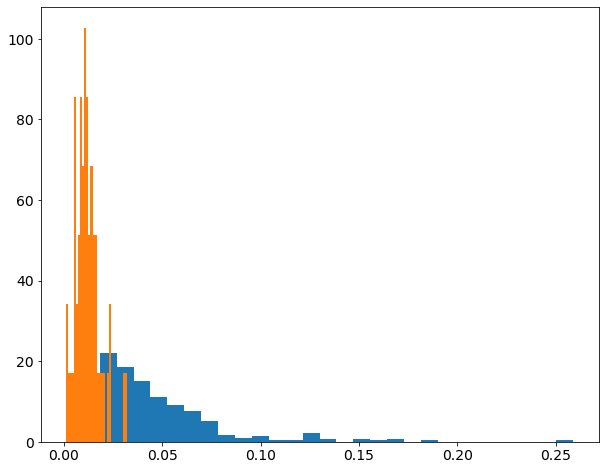

In [15]:
#working on nuTauAngle3D 4 different PDFs 
#trying to just do magnitude first 

#tau pT

nuTauAngle_had_0 = np.arccos(((df.tau_0_p_x*df.tau_0_matched_decay_neutrino_p_x)+(df.tau_0_p_y*df.tau_0_matched_decay_neutrino_p_y)+
                        (df.tau_0_p_z*df.tau_0_matched_decay_neutrino_p_z))/
                           (df.tau_0_p_p*df.tau_0_matched_decay_neutrino_p_p))[df.tau_0_p_p < 150]
nuTauAngle_had_1 = np.arccos(((df.tau_0_p_x*df.tau_0_matched_decay_neutrino_p_x)+(df.tau_0_p_y*df.tau_0_matched_decay_neutrino_p_y)+
                        (df.tau_0_p_z*df.tau_0_matched_decay_neutrino_p_z))/
                           (df.tau_0_p_p*df.tau_0_matched_decay_neutrino_p_p))[(df.tau_0_p_p < 300) & (df.tau_0_p_p > 150) ] 

nuTauAngle_had = np.arccos(((df.tau_0_p_x*df.tau_0_matched_decay_neutrino_p_x)+(df.tau_0_p_y*df.tau_0_matched_decay_neutrino_p_y)+
                        (df.tau_0_p_z*df.tau_0_matched_decay_neutrino_p_z))/
                           (df.tau_0_p_p*df.tau_0_matched_decay_neutrino_p_p))

fig, ax = plt.subplots(figsize=(10,8))
#bin_heights, bin_borders, _ = plt.hist(df.tau_1_matched_decay_neutrino_p, bins=50, density=True, label='histogram')
bin_heights, bin_borders, _ = plt.hist(nuTauAngle_had_0, bins=30, density=True, label='histogram')
bin_heights, bin_borders, _ = plt.hist(nuTauAngle_had_1, bins=30, density=True, label='histogram')



30.030958

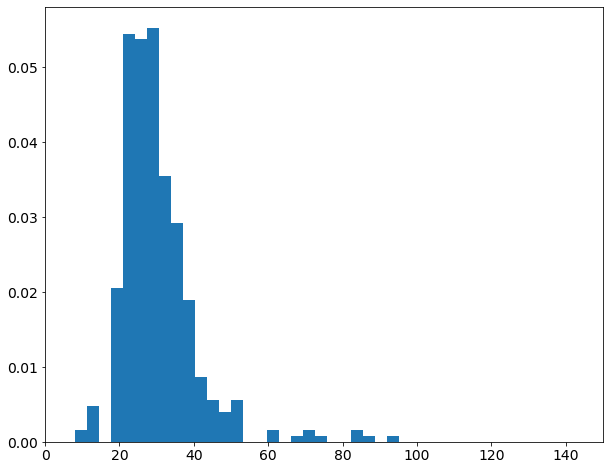

In [16]:
fig, ax = plt.subplots(figsize=(10,8))
bin_heights, bin_borders, _ = plt.hist(df.tau_0_leadTrk_pt, bins=300, density=True, label='histogram')
plt.xlim(0,150)
#np.max(df.tau_0_p_p)
#df.tau_0_p_p[len(df.tau_0_p_p)]
df.tau_0_leadTrk_pt.values[len(df.tau_0_leadTrk_pt)-1]

In [17]:
def find_slices(hist, pT, desired_bins):
    threshold = np.ceil(len(hist)/desired_bins) #how many events in each pT bin
    previous = 0
    ranges = [{0,0}]
    
    #step through ordered pT, and add a cut when you reach the threshold, then reset
    for vals in np.sort(pT):
        eggs = len(hist[(pT>previous)&(pT<vals)]) #how many eggs in the basket?
        if (eggs == threshold) or (vals == np.sort(pT)[len(pT)-1]): #control for last bin
            ranges.append({previous, vals}) #this is your pT cut 
            previous = vals
    return ranges    
test_ranges = find_slices(nuTauAngle_had, df.tau_0_allTrk_pt, 5)

In [18]:
[[0], [0, 23.606438], [27.305656, 23.606438], [27.305656, 30.784054], [36.468567, 30.784054], [36.468567, 989.1584]]

[[0],
 [0, 23.606438],
 [27.305656, 23.606438],
 [27.305656, 30.784054],
 [36.468567, 30.784054],
 [36.468567, 989.1584]]

In [19]:
test_ranges = find_slices(nuTauAngle_had, df.tau_0_leadTrk_pt, 8)
test_ranges.pop(0)

print(test_ranges)

#start, stop = zip(*test_ranges)
#print('start')
#print(start)
#print('stop')
#print(stop)

#(start, stop) = test_ranges

#fig, ax = plt.subplots(figsize=(10,8))
#bin_heights, bin_borders, _ = plt.hist(df.tau_1_matched_decay_neutrino_p, bins=50, density=True, label='histogram')
#for cut in start:
    #print(cut)
    #bin_heights, bin_borders, _ = plt.hist(nuTauAngle_had[(df.tau_0_leadTrk_pt>cut[0])&(df.tau_0_leadTrk_pt<cut[1])], bins=20, density=True, label='histogram')


[{0, 21.909164}, {24.197727, 21.909164}, {24.197727, 26.539545}, {26.539545, 28.858505}, {28.858505, 31.764616}, {35.37512, 31.764616}, {43.03933, 35.37512}, {43.03933, 973.46}]


/Users/ibhallaladd/Desktop/venv/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/ibhallaladd/Desktop/venv/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/ibhallaladd/Desktop/venv/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/ibhallaladd/Desktop/venv/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


My Params        | [ 1.28441930e+01  6.65577293e-01 -8.05687635e-04  1.21345069e-02]
My Params        | [ 1.88813560e+01  4.20554121e-01 -3.81015751e-03  6.91052832e-03]
My Params        | [1.15428829e+01 1.46444167e+07 1.03088264e+02 1.03121226e+02]
My Params        | [ 1.86606793e+01  4.72428890e-01 -2.90366549e-03  7.50387139e-03]


/Users/ibhallaladd/Desktop/venv/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/ibhallaladd/Desktop/venv/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/ibhallaladd/Desktop/venv/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/ibhallaladd/Desktop/venv/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


My Params        | [ 1.47203798e+01  5.70947048e-01 -3.59924181e-03  1.28142418e-02]
My Params        | [9.52108683e+00 2.25186057e+06 8.46136154e+01 8.46268474e+01]
My Params        | [11.68308501  4.69374058  0.02873186  0.06151994]
My Params        | [ 1.52844246e+01  2.92074051e-01 -5.20347285e-03  3.68210112e-03]


/Users/ibhallaladd/Desktop/venv/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  
/Users/ibhallaladd/Desktop/venv/lib/python3.7/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/Users/ibhallaladd/Desktop/venv/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  
/Users/ibhallaladd/Desktop/venv/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  
/Users/ibhallaladd/Desktop/venv/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


(-100.0, 120.0)

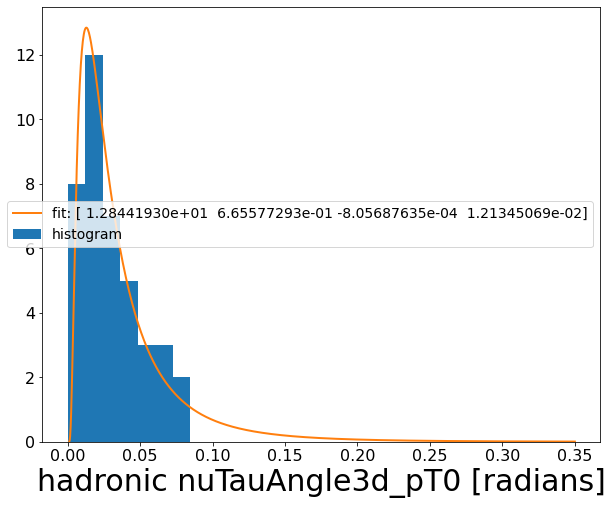

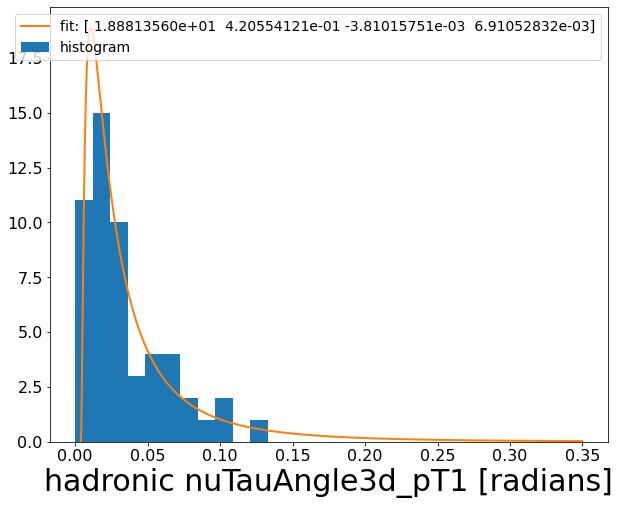

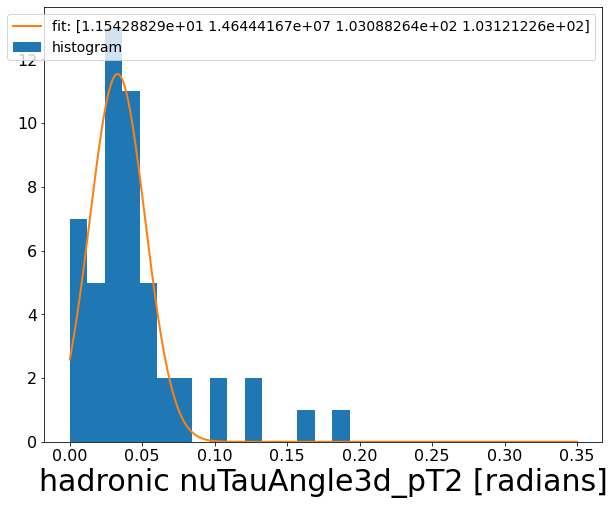

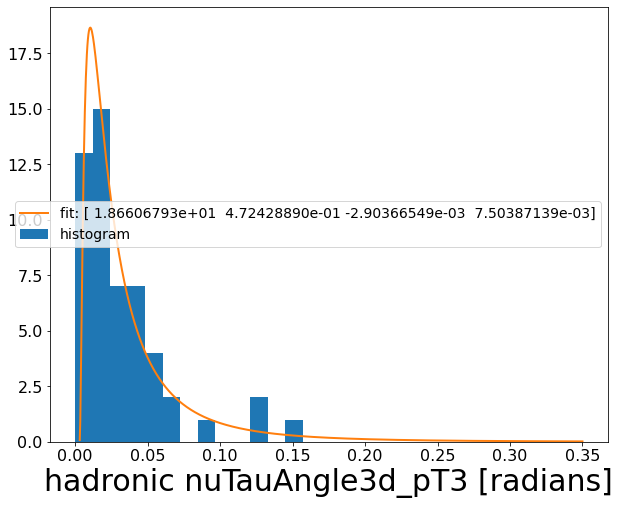

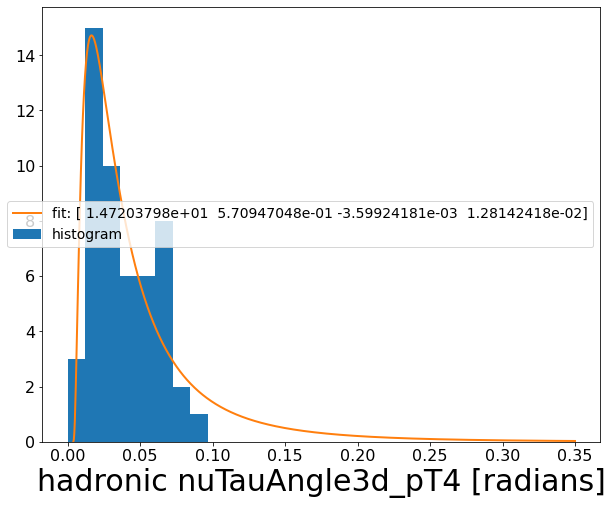

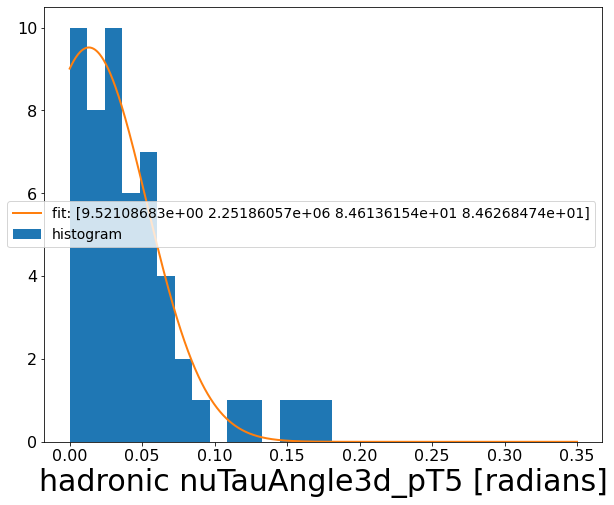

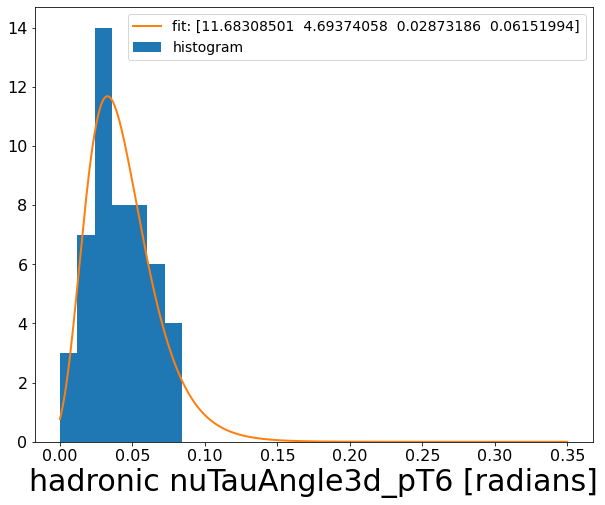

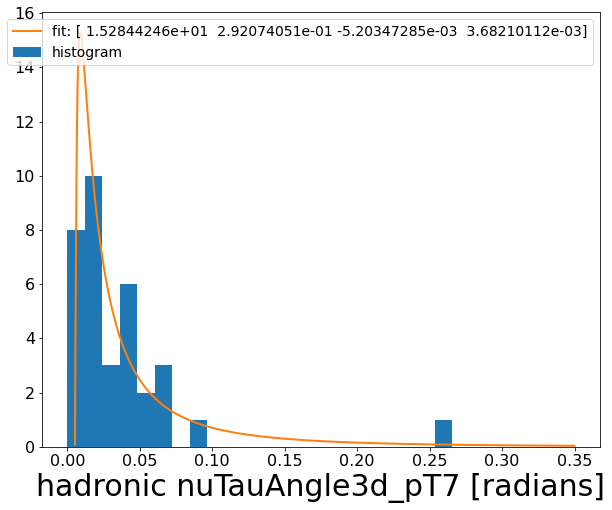

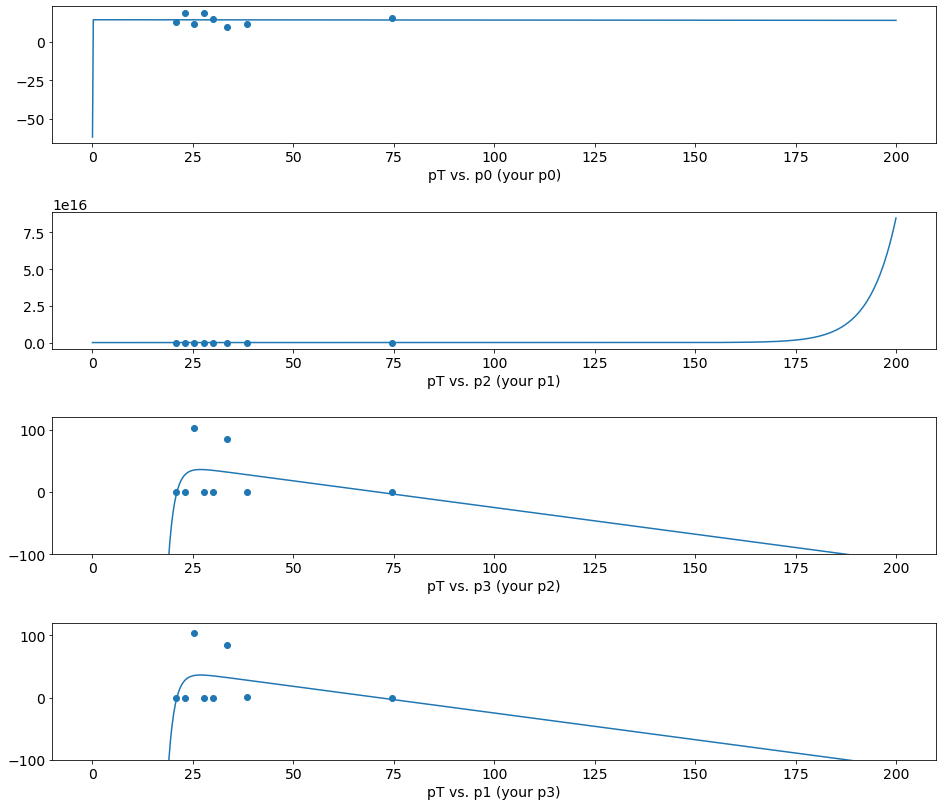

In [64]:
#working on new PDFs

#cuts = [[0, 22.336124], [22.336124, 24.417652], [24.417652, 26.869095], [26.869095, 28.963282], [28.963282, 31.862545], [31.862545,35.37512], [35.37512, 43.03933], [43.03933, 400]]
cuts = [[0, 24.32966], [24.32966, 28.858505], [28.858505, 35.070118], [35.070118, 400.0]]


cuts = [[0, 21.909164], [21.909164, 24.197727], [24.197727, 26.539545], [26.539545, 28.858505], 
        [28.858505, 31.764616], [31.764616, 35.37512], [35.37512, 43.03933], [43.03933, 400.0]]


#changing them to look like Michael's
#cuts = [[0, 40.0], [40.0,45.0], [45.0, 47.0], [47.0, 50.0], [50.0, 57.0], [57.0, 67.0], [67.0,99.0]]
#changed last elem to 200
#cuts = [[0.0, 23.606438], [23.606438, 27.305656], [27.305656, 30.784054], [30.784054, 36.468567], [36.468567, 200.0]]


#interpolated assumes a gaussian in pT, this is not true, changing to weighted_pT_cuts
interpolated_cuts = np.zeros(len(cuts))
interpolated_cuts_err = np.zeros(len(cuts))


weighted_pT_cuts = np.zeros(len(cuts))

i = 0

for elem in cuts: 
    interpolated_cuts[i] = (elem[0]+elem[1])/2
    interpolated_cuts_err[i] = (elem[1]-elem[0])/2
    #print(elem[0])
    weighted_pT_cuts[i] = np.mean(df.tau_0_allTrk_pt[(df.tau_0_allTrk_pt>(elem[0]))&(df.tau_0_allTrk_pt<(elem[1]))])
    
    i = i + 1
    
#print(interpolated_cuts)
#print('weighted_pT_cuts' + str(weighted_pT_cuts))

#nuTauAngle_had_pT = []
par0 = np.zeros(len(cuts))
par1 = np.zeros(len(cuts))
par2 = np.zeros(len(cuts))
par3 = np.zeros(len(cuts))

count = 0

for slice in cuts:
    #print(cuts[count][1])
    nuTauAngle_had_pT = np.arccos(((df.tau_0_p_x*df.tau_0_matched_decay_neutrino_p_x)+(df.tau_0_p_y*df.tau_0_matched_decay_neutrino_p_y)+
                            (df.tau_0_p_z*df.tau_0_matched_decay_neutrino_p_z))/
                               (df.tau_0_p_p*df.tau_0_matched_decay_neutrino_p_p))[(df.tau_0_allTrk_pt>(cuts[count][0]))&(df.tau_0_allTrk_pt<(cuts[count][1]))]

    params = calculate_hist_pT(nuTauAngle_had_pT,"hadronic nuTauAngle3d_pT" + str(count)+" [radians]", log_normal, bins=np.linspace(0,0.35,30))
    
    par0[count] = params[0]
    par1[count] = params[1]
    par2[count] = params[2]
    par3[count] = params[3]
    count = count + 1

    #labels are Michael's key

x_interval = np.linspace(0, 200, 1000)
fig, (ax0, ax1, ax2, ax3) = plt.subplots(4, figsize=(14,12))
fig.tight_layout(pad=3.0)

#ax0.errorbar(interpolated_cuts, par0, xerr=interpolated_cuts_err)
ax0.scatter(weighted_pT_cuts, par0)
popt0, _ = curve_fit(fit_pT, weighted_pT_cuts, par0, maxfev=10000000)
ax0.plot(x_interval, fit_pT(x_interval, *popt0))
ax0.set_xlabel('pT vs. p0 (your p0)')


ax3.scatter(weighted_pT_cuts, par3)
popt3, _ = curve_fit(fit_pT, weighted_pT_cuts, par3, maxfev=1000000)
ax3.plot(x_interval, fit_pT(x_interval, *popt3))
ax3.set_xlabel('pT vs. p1 (your p3)')
ax3.set_ylim(-100,120)

ax1.scatter(weighted_pT_cuts, par1)
popt1, _ = curve_fit(fit_pT, weighted_pT_cuts, par1, maxfev=1000000)
ax1.plot(x_interval, fit_pT(x_interval, *popt1))
ax1.set_xlabel('pT vs. p2 (your p1)')

ax2.scatter(weighted_pT_cuts, par2)
popt2, _ = curve_fit(fit_pT, weighted_pT_cuts, par2, maxfev=1000000)
ax2.plot(x_interval, fit_pT(x_interval, *popt2))
ax2.set_xlabel('pT vs. p3 (your p2)')
ax2.set_ylim(-100,120)
#ax2.set_ylim(-10,100)





#conversion key between your parameters and michael's
#you | Michael
#p0 = p0
#p1 = p2
#p2 = p3
#p3 = p1


/Users/ibhallaladd/Desktop/venv/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


Text(0.5, 0, 'pT vs. params p1')

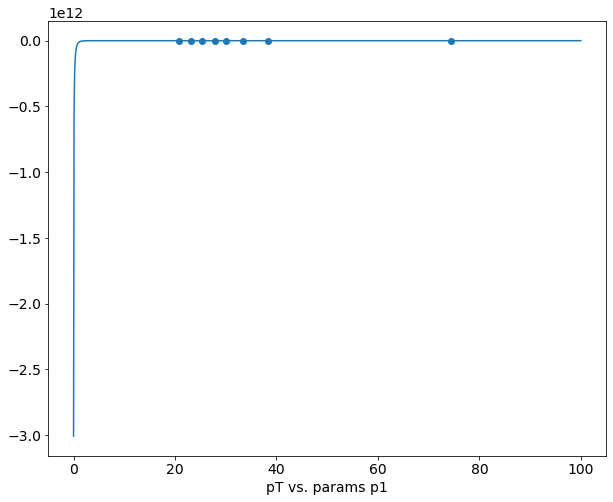

In [57]:
x_interval = np.linspace(0, 100, 1000)
fig, ax3 = plt.subplots(figsize=(10,8))
ax3.scatter(weighted_pT_cuts, par2)
popt0, _ = curve_fit(fit_pT, weighted_pT_cuts, par2, maxfev=1000000)
ax3.plot(x_interval, fit_pT(x_interval, *popt0))
ax3.set_xlabel('pT vs. params p1')
#ax3.set_ylim(0,50)


In [ ]:
par1

number of entries: 394
bin width: 0.004729729729729729


ValueError: invalid callable given

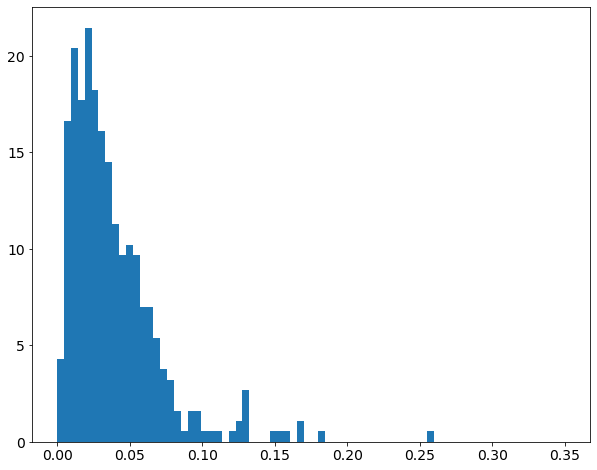

In [21]:
nuTauAngle_had = np.arccos(((df.tau_0_p_x*df.tau_0_matched_decay_neutrino_p_x)+(df.tau_0_p_y*df.tau_0_matched_decay_neutrino_p_y)+
                        (df.tau_0_p_z*df.tau_0_matched_decay_neutrino_p_z))/
                           (df.tau_0_p_p*df.tau_0_matched_decay_neutrino_p_p))
calculate_hist(nuTauAngle_had,"hadronic nuTauAngle3d [radians]", log_normal, m_params=[0.106, 1, 0.00241, 0.0165], m_integral=0.00467, bins=np.linspace(0,0.35,75))


number of entries: 394
bin width: 0.004054054054054054


ValueError: invalid callable given

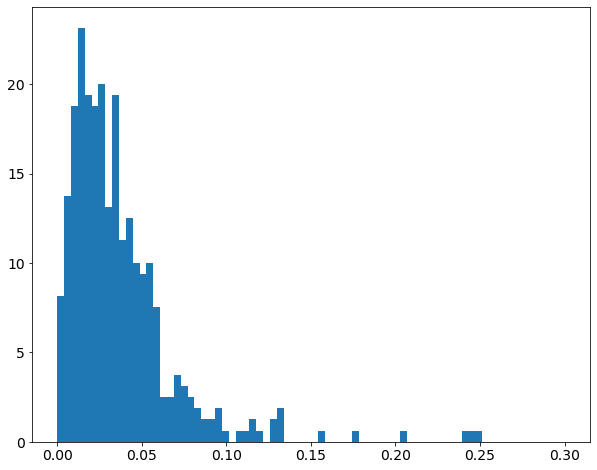

In [29]:
nuTauAngle_lep = np.arccos(((df.tau_1_p_x*df.tau_1_matched_decay_neutrino_p_x)+
                        (df.tau_1_p_y*df.tau_1_matched_decay_neutrino_p_y)+
                        (df.tau_1_p_z*df.tau_1_matched_decay_neutrino_p_z)) 
                               / (df.tau_1_p_p*df.tau_1_matched_decay_neutrino_p_p))
calculate_hist(nuTauAngle_lep,"leptonic nuTauAngle3d [radians]", log_normal, m_params=[0.10589, 1, 0.002434, 0.0166,], m_integral=0.004,bins=np.linspace(0,0.3,75))

number of entries: 394
bin width: 0.036734693877551024


ValueError: invalid callable given

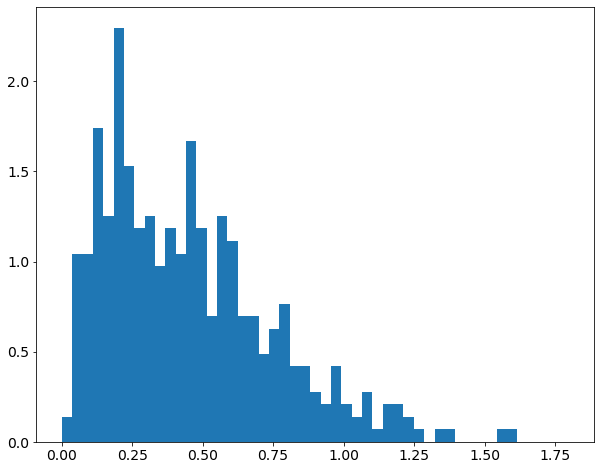

In [30]:
nuTauRatio_had = df.tau_0_matched_decay_neutrino_p/df.tau_0_p
calculate_hist(nuTauRatio_had,"hadronic nuTauRatio", fit_nuTau, m_params=[0.948, -2.51, 1.13], m_integral=0.036, bins=np.linspace(0,1.8, 50))

#from slide 4: m_params=[-0.802,-0.712, -0.464, -1.38, -1.59]
#from slide 5: m_params=[0.0659, 1.6776, 0.45497, 0.47949, 0.529]

number of entries: 394
bin width: 0.10204081632653061


ValueError: invalid callable given

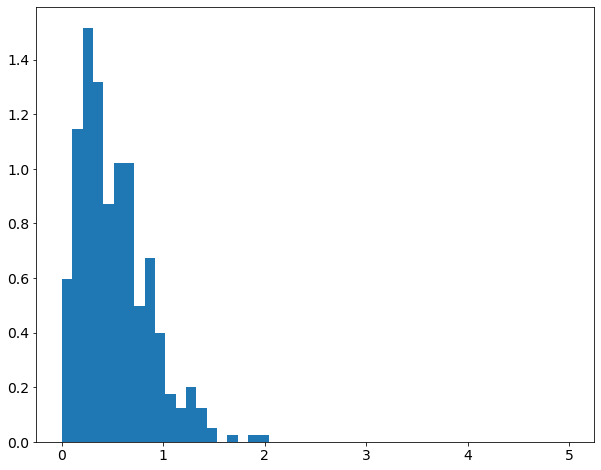

In [31]:
nuTauRatio_lep = df.tau_1_matched_decay_neutrino_p/df.tau_1_p_p
calculate_hist(nuTauRatio_lep,"leptonic nuTauRatio", fit_function, m_params=[-0.802,-0.712, -0.464, -1.38, -1.59], m_integral=0.1, bins=np.linspace(0,5, 50))


(1.35, 1.55)

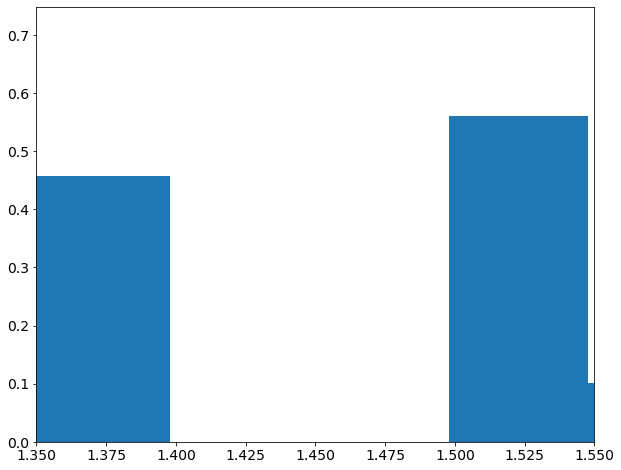

In [19]:
nuTauRatio_lep = df.tau_1_matched_decay_neutrino_p/df.tau_1_p_p

fig, ax = plt.subplots(figsize=(10,8))
bin_heights, bin_borders, _ = plt.hist(df.tau_0_allTrk_eta, bins=100, density=True, label='histogram')

#np.linspace(0,5, 50)
plt.xlim(1.35, 1.55)
#1.37, 1.52


In [27]:
def pdf_to_ROOT(name, hist, bins):
#     with uproot.recreate(str(name)+".root") as f:
#         f["t"] = uproot.newtree({"branch": "int32"})
#         f["t"].extend({"branch": numpy.array([1, 2, 3, 4, 5])})
    #WILL EVENTUALLY NEED TO FIGURE OUT HOW TO MAKE A TTREE, MIGHT JUST SO THAT PART IN ROOT ONCE HAVE HISTS
    import types
    import uproot_methods.classes.TH1
    
    file = uproot.recreate("/Users/ibhallaladd/Desktop/temp_research/"+str(name)+".root", compression=uproot.ZLIB(4))
    file[name] = np.hist(hist, bins=bins, normed=True)

In [24]:
import types
import uproot_methods.classes.TH1
    
file = uproot.recreate("/Users/ibhallaladd/Desktop/temp_research/"+"tau_0_eta"+".root", compression=uproot.ZLIB(4))
#file['tau_0_eta'] = plt.hist(df.tau_0_allTrk_eta, bins=100, density=True, label='histogram')
file['tau_0_eta'] = np.histogram(df.tau_0_allTrk_eta, bins=100, normed=True)

/Users/ibhallaladd/Desktop/venv/lib/python3.7/site-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  


In [ ]:
##THIS DOES NOT WORK, TROUBLESHOOTING ROOT BEFORE I CAN FIX THIS
#     gROOT.ProcessLine(
#     "struct MyStruct {\
#        Int_t     fMyInt1;\
#        Int_t     fMyInt2;\
#        Int_t     fMyInt3;\
#        Char_t    fMyCode[4];\
#     };" );

#     from ROOT import MyStruct
#     mystruct = MyStruct()

#     f = TFile( 'mytree.root', 'RECREATE' )
#     tree = TTree( 'T', 'Just A Tree' )
#     tree.Branch( 'myints', mystruct, 'MyInt1/I:MyInt2:MyInt3' )
#     tree.Branch( 'mycode', AddressOf( mystruct, 'fMyCode' ), 'MyCode/C' )

#     for i in range(10):
#        mystruct.fMyInt1   = i
#        mystruct.fMyInt2   = i*i
#        mystruct.fMyInt3   = i*i*i
#        mystruct.fMyCode   = "%03d" % i      # note string assignment

#        tree.Fill()

#     f.Write()
#     f.Close()